## Introduction

**Dataset selection: NHANES**

The data we are using comes from the National Health and Nutrition Examination Survey (NHANES) program at the CDC. NHANES is a research program designed to assess the health and nutritional status of adults and children in the United States. The survey is one of the only to combine both survey questions and physical examinations. It began in the 1960s and since 1999 examines a nationally representative sample of about 5,000 people each year. The NHANES interview includes demographic, socioeconomic, dietary, and health-related questions. The physical exam includes medical, dental, and physiological measurements, as well as several standard laboratory tests. NHANES is used to determine the prevalence of major diseases and risk factors for those diseases. We focus on the Diabetes related data in order to form a prediction model.


We are using a handful of variables from the 2011-2012 survey years on about 5,000 individuals. The CDC uses a sampling strategy to purposefully oversample certain subpopulations like racial minorities. Naive analysis of the original NHANES data can lead to mistaken conclusions because the percentages of people from each racial group in the data are different from general population. The 5,000 individuals here are resampled from the larger NHANES study population to undo these oversampling effects, so you can treat this as if it were a simple random sample from the American population.

**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding, Flatten, Activation
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from IPython.display import display, HTML
from scipy.stats import pearsonr
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


**Load the data**

Nhanes dataset consists of 31 columns relevant with demographic, socioeconomic, dietary, and health-related informations of 5000 individuals.

In [2]:
df = pd.read_csv("nhanes.csv")
df.columns
df.head(10)

,Diabetes,Gender,Age,Race,Education,MaritalStatus,RelationshipStatus,Insured,Income,Poverty,...,TotChol,DiabetesAge,nPregnancies,nBabies,SleepHrsNight,PhysActive,PhysActiveDays,AlcoholDay,AlcoholYear,SmokingStatus
0,No,male,14,Asian,NaN,NaN,NaN,Yes,100000.0,4.07,...,3.98,NaN,NaN,NaN,NaN,No,1.0,NaN,NaN,NaN
1,No,female,43,Black,High School,NeverMarried,Single,Yes,22500.0,2.02,...,4.37,NaN,3.0,2.0,8.0,No,2.0,3.0,104.0,Current
2,No,male,80,White,College Grad,Married,Committed,Yes,70000.0,4.30,...,5.25,NaN,NaN,NaN,9.0,No,7.0,NaN,0.0,Never
3,No,male,80,White,College Grad,Married,Committed,Yes,70000.0,4.30,...,5.25,NaN,NaN,NaN,9.0,No,5.0,NaN,0.0,Never
4,No,male,5,White,NaN,NaN,NaN,Yes,12500.0,0.39,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN
5,No,female,34,White,College Grad,Married,Committed,Yes,100000.0,5.00,...,4.42,NaN,5.0,2.0,7.0,Yes,5.0,2.0,104.0,Never
6,No,male,80,White,High School,Widowed,Single,Yes,2500.0,0.05,...,5.20,NaN,NaN,NaN,6.0,No,NaN,NaN,NaN,Never
7,No,male,35,White,College Grad,Married,Committed,Yes,22500.0,0.87,...,3.70,NaN,NaN,NaN,7.0,No,NaN,1.0,2.0,Never
8,No,female,17,Black,NaN,NaN,NaN,Yes,22500.0,0.53,...,3.21,NaN,NaN,NaN,7.0,Yes,4.0,NaN,NaN,NaN
9,No,female,15,Mexican,NaN,NaN,NaN,Yes,30000.0,0.54,...,4.11,NaN,NaN,NaN,NaN,No,7.0,NaN,NaN,NaN


## DATA PREPROCESSING

**Handling missing values**

We estimate for each variable the missing values percentage and we exclude the ones having a percentage greater or equal to 40%.

In [3]:
#finding the % of mising values in each column
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,'percent_missing': percent_missing})
#sort descending order
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,column_name,percent_missing
DiabetesAge,DiabetesAge,93.86
nBabies,nBabies,76.64
nPregnancies,nPregnancies,74.70
PhysActiveDays,PhysActiveDays,52.28
AlcoholDay,AlcoholDay,50.06
AlcoholYear,AlcoholYear,40.32
Education,Education,28.32
MaritalStatus,MaritalStatus,28.30
RelationshipStatus,RelationshipStatus,28.30
SmokingStatus,SmokingStatus,28.26


In [4]:
for i in range(0, len(df.columns)):
    if missing_value_df.percent_missing[i] > 40:
        df.drop([missing_value_df.column_name[i]], axis=1,inplace=True)
df.columns

Index(['Diabetes', 'Gender', 'Age', 'Race', 'Education', 'MaritalStatus',
       'RelationshipStatus', 'Insured', 'Income', 'Poverty', 'HomeRooms',
       'HomeOwn', 'Work', 'Weight', 'Height', 'BMI', 'Pulse', 'BPSys', 'BPDia',
       'Testosterone', 'HDLChol', 'TotChol', 'SleepHrsNight', 'PhysActive',
       'SmokingStatus'],
      dtype='object')

We transformded non-numerical data into numerical data. Then we handle missing values by replacing them with the average value of each column.

In [5]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
for i in range(0, len(df.columns)):
    if df[df.columns[i]].dtype==object:
        df[df.columns[i]].fillna(df[df.columns[i]].mode()[0],inplace=True)
        df[[df.columns[i]]] = enc.fit_transform(df[[df.columns[i]]])
    else:
        df[df.columns[i]].fillna(df[df.columns[i]].mean(),inplace=True)
        
df.head(21)

,Diabetes,Gender,Age,Race,Education,MaritalStatus,RelationshipStatus,Insured,Income,Poverty,...,BMI,Pulse,BPSys,BPDia,Testosterone,HDLChol,TotChol,SleepHrsNight,PhysActive,SmokingStatus
0,0.0,1.0,14,0.0,4.0,2.0,0.0,1.0,100000.0,4.07,...,17.3,72.000000,107.000000,37.000000,274.950,1.140000,3.980000,6.906103,0.0,2.0
1,0.0,0.0,43,1.0,3.0,3.0,1.0,1.0,22500.0,2.02,...,33.3,80.000000,103.000000,72.000000,47.530,1.890000,4.370000,8.000000,0.0,0.0
2,0.0,1.0,80,5.0,2.0,2.0,0.0,1.0,70000.0,4.30,...,33.9,56.000000,97.000000,39.000000,642.820,1.400000,5.250000,9.000000,0.0,2.0
3,0.0,1.0,80,5.0,2.0,2.0,0.0,1.0,70000.0,4.30,...,33.9,56.000000,97.000000,39.000000,642.820,1.400000,5.250000,9.000000,0.0,2.0
4,0.0,1.0,5,5.0,4.0,2.0,0.0,1.0,12500.0,0.39,...,16.7,73.633816,118.704508,68.301565,197.898,1.361034,4.830888,6.906103,1.0,2.0
5,0.0,0.0,34,5.0,2.0,2.0,0.0,1.0,100000.0,5.00,...,23.3,92.000000,107.000000,69.000000,21.110,1.420000,4.420000,7.000000,1.0,2.0
6,0.0,1.0,80,5.0,3.0,5.0,1.0,1.0,2500.0,0.05,...,28.5,68.000000,121.000000,72.000000,562.780,1.220000,5.200000,6.000000,0.0,2.0
7,0.0,1.0,35,5.0,2.0,2.0,0.0,1.0,22500.0,0.87,...,27.9,66.000000,107.000000,66.000000,401.780,0.850000,3.700000,7.000000,0.0,2.0
8,0.0,0.0,17,1.0,4.0,2.0,0.0,1.0,22500.0,0.53,...,22.9,86.000000,108.000000,64.000000,27.000,1.400000,3.210000,7.000000,1.0,2.0
9,0.0,0.0,15,3.0,4.0,2.0,0.0,1.0,30000.0,0.54,...,17.0,76.000000,113.000000,27.000000,22.200,1.630000,4.110000,6.906103,0.0,2.0


In [6]:
y = df["Diabetes"] 
x = df.loc[:, "Gender":]


**Checking correlation between target variable and predictors**
We check correlation between each column and the target variable so as to reject the variables who are weakly correlated. Lastly, we calculate the correlation between columns in order to avoid overfitting.

In [7]:
corrlist=[]

for i in range(1, len(df.columns)):
    
    corr,_=pearsonr(df[df.columns[i]],df[df.columns[0]])
    corrlist.append(abs(corr))
    
corrlist_df = pd.DataFrame({'column_name': x.columns,'corr': corrlist})
#sort descending order
corrlist_df.sort_values('corr', inplace=True, ascending=False)

corrlist_df

,column_name,corr
1,Age,0.272359
14,BMI,0.237018
12,Weight,0.201313
16,BPSys,0.185311
22,PhysActive,0.154819
11,Work,0.133209
3,Education,0.098831
19,HDLChol,0.097588
7,Income,0.082754
13,Height,0.082576


**Checking correlation between columns**

In [8]:
def mosthighlycorrelated(mydataframe, numtoreport):
    cormatrix = mydataframe.corr()
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    return cormatrix.head(numtoreport)

mosthighlycorrelated(df, 20)



,FirstVariable,SecondVariable,Correlation
0,Income,Poverty,0.881111
1,Weight,BMI,0.845161
2,Weight,Height,0.710968
3,Gender,Testosterone,0.697495
4,Age,Weight,0.523036
5,HomeRooms,HomeOwn,-0.486085
6,Age,Education,-0.458024
7,Age,Height,0.454824
8,Height,BMI,0.444707
9,Age,BPSys,0.442811


**Feature selection**

In [9]:
simplified_df = pd.DataFrame({'Diabetes':df["Diabetes"],'Age':df["Age"],'BMI':df["BMI"],'PhysActive':df["PhysActive"],'Education':df["Education"],
                              'HDLChol':df["HDLChol"],'Income':df["Income"],'RelationshipStatus':df["RelationshipStatus"],
                              'BPDia':df["BPDia"],'Insured':df["Insured"],'SleepHrsNight':df["SleepHrsNight"]})

simplified_df.head(100)

,Diabetes,Age,BMI,PhysActive,Education,HDLChol,Income,RelationshipStatus,BPDia,Insured,SleepHrsNight
0,0.0,14,17.3,0.0,4.0,1.140000,100000.0,0.0,37.000000,1.0,6.906103
1,0.0,43,33.3,0.0,3.0,1.890000,22500.0,1.0,72.000000,1.0,8.000000
2,0.0,80,33.9,0.0,2.0,1.400000,70000.0,0.0,39.000000,1.0,9.000000
3,0.0,80,33.9,0.0,2.0,1.400000,70000.0,0.0,39.000000,1.0,9.000000
4,0.0,5,16.7,1.0,4.0,1.361034,12500.0,0.0,68.301565,1.0,6.906103
...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,43,22.3,1.0,3.0,1.860000,40000.0,1.0,67.000000,1.0,6.000000
96,0.0,43,22.3,1.0,3.0,1.860000,40000.0,1.0,67.000000,1.0,6.000000
97,0.0,43,22.3,1.0,3.0,1.860000,40000.0,1.0,67.000000,1.0,6.000000
98,0.0,7,18.7,1.0,4.0,1.010000,22500.0,0.0,68.301565,1.0,6.906103


**Diabetes percentage**

0 stands for No and 1 stands for Yes. 

We observe an unequal distribution of active Diabetes cases and non active cases. In this specific dataset the ratio is 9:1 for Yes and No respectively. At the following steps we manipulate the imbalanced data with imbalanced-learn python library.


In [10]:
simplified_df['Diabetes'].value_counts(normalize=True) * 100

0.0    92.54
1.0     7.46
Name: Diabetes, dtype: float64

**Predictors**

Age \hspace{2cm}|Age in years at screening of study participant. Note: Subjects 80 years or older were recorded as 80.

BMI \hspace{2cm}|Body mass index (weight/height2 in kg/m2). Reported for participants aged 2 years or older.

Education \hspace{2cm}|Educational level of study participant Reported for participants aged 20 years or older. One of 8thGrade(0), 9-11thGrade(1), HighSchool(3), SomeCollege(4), or CollegeGrad(2).  

RelationshipStatus \hspace{2cm}|Simplification of MaritalStatus, coded as Committed(0) if MaritalStatus is Married or LivePartner, and Single(1) otherwise. 

SleepHrsNight   \hspace{2cm}   |Self-reported number of hours study participant usually gets at night on weekdays or workdays. Reported for participants aged 16 years and older.      

PhysActive      \hspace{2cm}   |Participant does moderate or vigorous-intensity sports, fitness or recreational activities (Yes(1) or No(0)). Reported for participants 12 years or older.  

Income     \hspace{2cm}        |Numerical version of HHIncome derived from the middle income in each category   

Insured    \hspace{2cm}        |Indicates whether the individual is covered by health insurance. (Yes(1) , No(1))  

BPDia        \hspace{2cm}      |Combined diastolic blood pressure reading, following the procedure outlined for BPXDAR.

HDLChol      \hspace{2cm}      |Direct HDL cholesterol in mmol/L. Reported for participants aged 6 years or older. 


## Data Analysis

**Histograms**

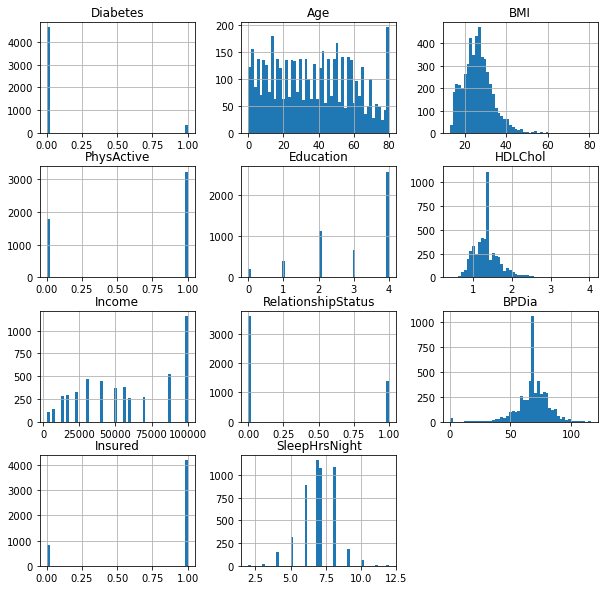

In [11]:
simplified_df.hist(figsize=(10,10),bins=50)
plt.show()

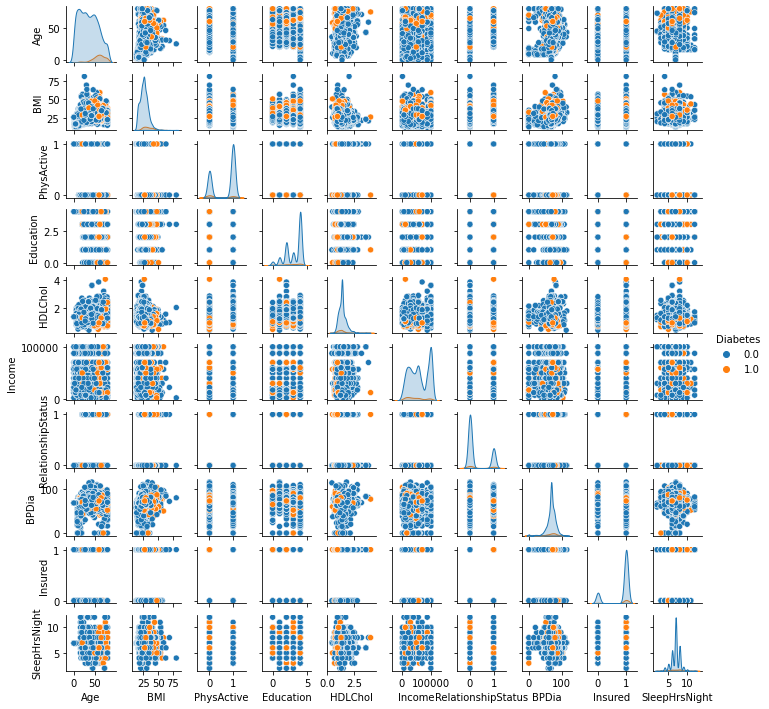

In [12]:
sns.pairplot(simplified_df,hue='Diabetes', height=1)
plt.show()

**Correlation**

<AxesSubplot:>

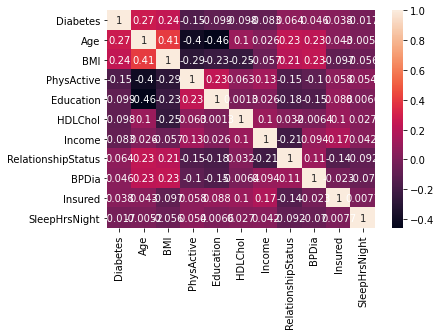

In [13]:
corr = simplified_df.corr()
sns.heatmap(corr,annot=True)

**Splitting Dataset and handling Imbalanced Data** 

Resampling involves creating a new transformed version of the training dataset in which the selected examples have a different class distribution.Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset. Random undersampling involves randomly selecting examples from the majority class and deleting them from the training dataset.

*Random oversampling is prefered due to greatest accuracy

In [14]:
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

Y = simplified_df["Diabetes"] 
X = simplified_df.loc[:, "Age":]

# define undersampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X , Y = oversample.fit_resample(X , Y)


#Split dataset
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)


print("X train shape" , X_train.shape)
print("X test shape" , X_test.shape)
print("Y train shape", Y_train.shape)
print("Y test shape" , Y_test.shape)


X train shape (7403, 10)
X test shape (1851, 10)
Y train shape (7403,)
Y test shape (1851,)


In [15]:
from sklearn.preprocessing import StandardScaler 
# Define the scaler  
sc = StandardScaler().fit(X_train) 
# Scale the train set 
X_train = sc.transform(X_train) 
# Scale the test set 
X_test = sc.transform(X_test)


## Model Fitting
 
 
This is a classification problem, with the target variable having values '0' and '1'

**Decission tree**

A decision tree is a diagram or chart that helps determine a course of action or show a statistical probability. It approximates discrete-valued target functions while being robust to noisy data and learns complex patterns in the data. The main idea of a decision tree is to identify the features which contain the most information regarding the target feature and then split the dataset along the values of these features such that the target feature values at the resulting nodes are as pure as possible. A feature that best separates the uncertainty from information about the target feature is said to be the most informative feature.




**Decission Tree with entropy**

This approach is used to measure the impurity or randomness of a dataset. In two target feauture case , Shannon’s entropy model uses the logarithm function with base 2 (log2(P(x)) to measure the entropy because as the probability P(x) of randomly select one of the two possible target feautures increases, the result approaches closer to binary logarithm 1. This finally leads us to the formal definition of Shannon’s entropy which serves as the baseline for the information gain calculation:

*Entropy(x) = - $\sum({P(x=k)*log_{2}P(x=k)})$*

To find the best feature which serves as a root node in terms of information gain, we estimate

*InformationGain(feauture) = Entropy(Dataset) - Entropy(feature)* 

The feature with the largest information gain should be used as the root node to start building the decision tree.




In [16]:
model_entropy = DecisionTreeClassifier(criterion='entropy',random_state=7)
model_entropy.fit(X_train,Y_train)
y_pred_test = model_entropy.predict(X_test)
y_pred_train = model_entropy.predict(X_train)

score_dte_test = round(accuracy_score(Y_test,y_pred_test)*100,4)
score_dte_train = round(accuracy_score(Y_train,y_pred_train)*100,4)

print("(train)The accuracy score achieved using Decission Tree with entropy is: "+str(score_dte_train)+" %")
print("(test)The accuracy score achieved using Decission Tree with entropy is: "+str(score_dte_test)+" %")

(train)The accuracy score achieved using Decission Tree with entropy is: 100.0 %
(test)The accuracy score achieved using Decission Tree with entropy is: 99.0816 %


**Decission Tree with Gini**

Gini index or Gini impurity measures the degree or probability of a particular variable being wrongly classified when it is randomly chosen. It is calculated by subtracting the sum of squared probabilities of each class from one. It favors larger partitions and easy to implement whereas information gain favors smaller partitions with distinct values.

*Gini Index = 1 -$\sum(P(x=k))^{2}$*

A feature with a lower Gini index is chosen for a split.

In [17]:
model_gini = DecisionTreeClassifier(criterion='gini',random_state=7)
model_gini.fit(X_train,Y_train)
y_pred_test = model_gini.predict(X_test)
y_pred_train = model_gini.predict(X_train)

score_dtg_test = round(accuracy_score(Y_test,y_pred_test)*100,4)
score_dtg_train = round(accuracy_score(Y_train,y_pred_train)*100,4)

print("(train)The accuracy score achieved using Decission Tree with Gini is: "+str(score_dtg_train)+" %")
print("(test)The accuracy score achieved using Decission Tree with Gini is: "+str(score_dtg_test)+" %")


(train)The accuracy score achieved using Decission Tree with Gini is: 100.0 %
(test)The accuracy score achieved using Decission Tree with Gini is: 99.0816 %


**Naive Bayes**

Naive Bayes is a family of probabilistic algorithms that take advantage of probability theory and Bayes’ Theorem to predict the target variable. They are probabilistic, which means that they calculate the probability of each tag for a given text, and then output the tag with the highest one. The way they get these probabilities is by using Bayes’ Theorem, which describes the probability of a feature, based on prior knowledge of conditions that might be related to that feature.

In [18]:
model_nb = GaussianNB()
model_nb.fit(X_train,Y_train)
y_pred_test = model_nb.predict(X_test)
y_pred_train = model_nb.predict(X_train)


score_nb_test = round(accuracy_score(Y_test,y_pred_test)*100,4)
score_nb_train = round(accuracy_score(Y_train,y_pred_train)*100,4)



print("(train)The accuracy score achieved using Naive Bayes is: "+str(score_nb_train)+" %")
print("(test)The accuracy score achieved using Naive Bayes is: "+str(score_nb_test)+" %")

(train)The accuracy score achieved using Naive Bayes is: 75.8071 %
(test)The accuracy score achieved using Naive Bayes is: 76.6613 %


**Support Vector Machine**

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.


To separate the two classes of data points, there are many possible hyperplanes that could be chosen. Hyperplanes are decision boundaries that help classify the data points. Our objective is to find a plane that has the maximum margin or the maximum distance between data points of both classes.

In [19]:
sv = svm.SVC()
sv.fit(X_train, Y_train)

Y_pred_svm_test = sv.predict(X_test)
Y_pred_svm_test.shape

Y_pred_svm_train = sv.predict(X_train)
Y_pred_svm_train.shape


score_svm_test = round(accuracy_score(Y_test,Y_pred_svm_test)*100,4)
score_svm_train = round(accuracy_score(Y_train,Y_pred_svm_train)*100,4)



print("(train)The accuracy score achieved using Linear SVM is: "+str(score_svm_train)+" %")
print("(test)The accuracy score achieved using Linear SVM is: "+str(score_svm_test)+" %")

(train)The accuracy score achieved using Linear SVM is: 88.5317 %
(test)The accuracy score achieved using Linear SVM is: 88.5467 %


**Trying Ensembles**

Ensembles means that instead of using a single model, you take the the help of multiple models for prediction. For making each prediction, the ML ensemble algorithm takes every model’s output and suggestion into account and then makes a final prediction. If you take multiple models into account, then chances are that all of them make different errors. Hence when an ensemble takes multiple models’ predictions into consideration, one particular model’s error will have minimal effect on the overall result. Hence the overall prediction will be with minimal errors.

**Ensemble of SVM , Decission Tree with Entropy and Naive Bayes**

In this case we use the above models (deriving from Decission Tree, Naive Bayes and SVM classification algorithms)

In [20]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('svc',sv),('nb', model_nb), ('decision', model_entropy)],voting='hard')
voting_clf.fit(X_train, Y_train)

scoreEn_test=voting_clf.score(X_test, Y_test)
score_en_test = round(scoreEn_test*100,4)

scoreEn_train=voting_clf.score(X_train, Y_train)
score_en_train = round(scoreEn_train*100,4)

print("(train)The accuracy score achieved using ensemble training is: "+str(score_en_train)+" %")
print("(test)The accuracy score achieved using ensemble training is: "+str(score_en_test)+" %")

(train)The accuracy score achieved using ensemble training is: 91.0036 %
(test)The accuracy score achieved using ensemble training is: 91.0319 %


**MLP**

In our dataset, we used a 3 layer fully connected perceptron , two of these layers use as activation function the 'relu' function and the final layer uses for the same purpose the sigmoid function. At the hidden layer we picked 12 hidden units which define the amount of freedom that we are allowing the network to have when it’s learning representations. Since we deal with a binary classification problem we apply the binary_crossentropy loss function. We train the model for 100 epochs or iterations over all the samples in X_train and Y_train, in batches of 1 sample. 

In [21]:
#reshape data 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))


In [23]:
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils

def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

# Hotfix function
def make_keras_picklable():

    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))

    cls = Model
    cls.__reduce__ = __reduce__

In [25]:
from keras.models import Model
make_keras_picklable()
# define model
MLPmodel = Sequential()
MLPmodel.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
MLPmodel.add(Dropout(0.2))
MLPmodel.add(Dense(12, activation='relu'))
MLPmodel.add(Dropout(0.2))
MLPmodel.add(Dense(1, activation='sigmoid'))
MLPmodel.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

**100 epochs**

In [26]:
# fit model
MLPmodel.fit(X_train, Y_train, epochs=5, batch_size=1, verbose=0)

# check predicted values
predictions = MLPmodel.predict(X_test)

# Undo scaling
#predictions = sc.inverse_transform(predictions)

score_test = MLPmodel.evaluate(X_test, Y_test,verbose=1)

score_MLP100_test = round(score_test[1]*100,4)

print("The accuracy score achieved using MLP and 100 epochs is: "+str(score_MLP100_test)+" %")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpep4ykgcp.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpep4ykgcp.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


NameError: name 'score_test' is not defined

In [27]:
import pickle
# Dump the trained decision tree classifier with Pickle
mlp_pkl_filename = 'mlp_classifier.pkl'
# Open the file to save as pkl file
mlp_model_pkl = open(mlp_pkl_filename, 'wb')
pickle.dump(MLPmodel, mlp_model_pkl)
# Close the pickle instances
mlp_model_pkl.close()

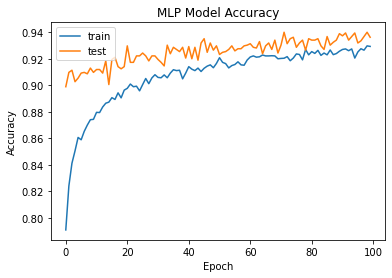

In [90]:
plt.plot(perceptron_model.history['accuracy'])
plt.title('MLP Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['test'],loc='upper left')
plt.show()

**Output final score**

                             train scores  test scores
Model                                                 
Decission Tree with entropy      100.0000      98.0011
Decission Tree with gini         100.0000      98.2712
MLP                               94.4887      96.8125
Ensemble                          91.5710      89.5192
Support Vector Machine            89.6123      87.6283
Naive Bayes                       74.9561      74.4462


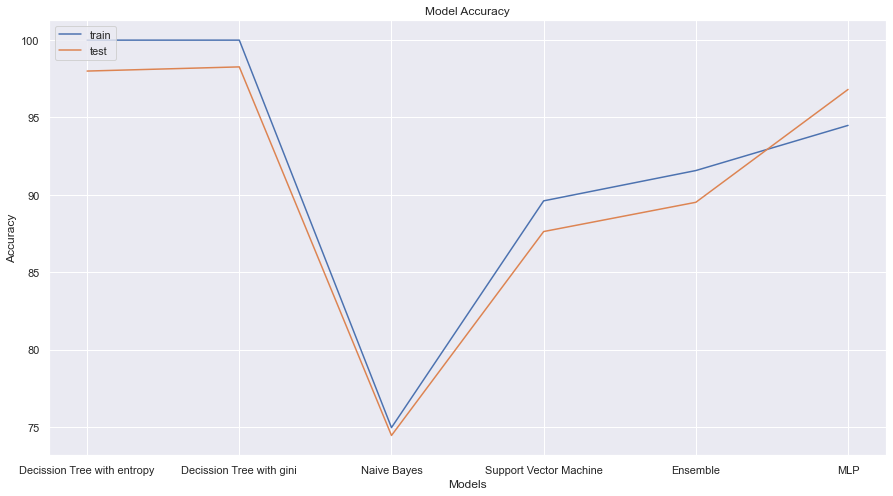

C:\Users\panag\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Algorithms', ylabel='Accuracy score'>

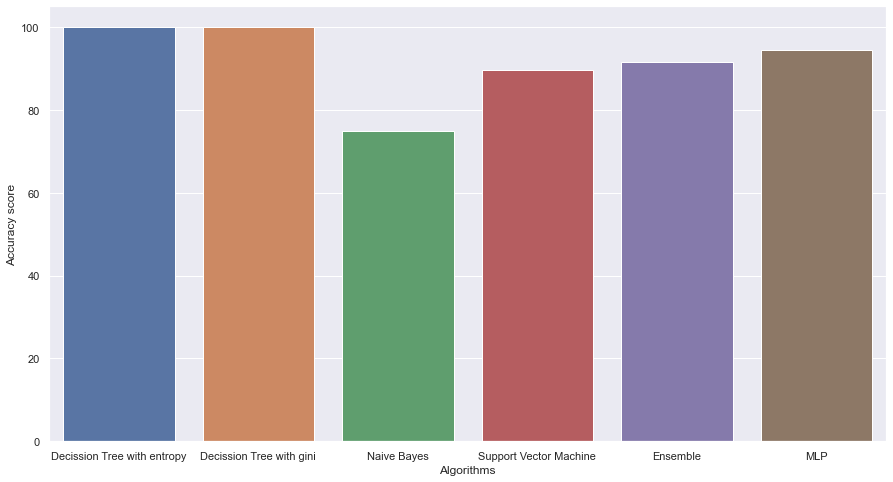

In [100]:
train_scores = [score_dte_train,score_dtg_train,score_nb_train,score_svm_train,score_en_train,score_MLP100_train]
test_scores =  [score_dte_test,score_dtg_test,score_nb_test,score_svm_test,score_en_test,score_MLP100_test]
algorithms = ["Decission Tree with entropy","Decission Tree with gini","Naive Bayes","Support Vector Machine","Ensemble","MLP"]    

results = pd.DataFrame({
    'Model' : ["Decission Tree with entropy","Decission Tree with gini","Naive Bayes","Support Vector Machine","Ensemble","MLP"],
    'train scores' : [score_dte_train,score_dtg_train,score_nb_train,score_svm_train,score_en_train,score_MLP100_train],
    'test scores' :  [score_dte_test,score_dtg_test,score_nb_test,score_svm_test,score_en_test,score_MLP100_test]})

best_train_scores = results.sort_values(by='train scores', ascending=False)
best_train_scores = best_train_scores.set_index('Model')
print(best_train_scores)

plt.plot(algorithms,train_scores)
plt.plot(algorithms,test_scores)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.legend(['train','test'],loc='upper left')
plt.show()
    
sns.set(rc={'figure.figsize':(15,8)})
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")

sns.barplot(algorithms,train_scores)